## install dependencies

## imports

In [2]:
!pip install pims

     |████████████████████████████████| 85 kB 1.3 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for pims: filename=PIMS-0.5-py3-none-any.whl size=84326 sha256=964c12c54182b4f66fa3cb6a26266559708e7300d46a91e11ff454cee0d9ebfb
  Stored in directory: /home/luclepot/.cache/pip/wheels/6c/69/f3/41140113aa50444a23e783a4288d4662797ebc4fa55edd6370
Successfully built pims


In [27]:
!pip install trackpy

     |████████████████████████████████| 131 kB 3.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for trackpy: filename=trackpy-0.5.0-py3-none-any.whl size=128767 sha256=9449ace4f5727454d1bf6f49f13d1653e7c9812b327d1ca20dc56b67886ea025
  Stored in directory: /home/luclepot/.cache/pip/wheels/f6/08/12/c940ca467827675521125cfed4a5b41dd7bb76efbbb128598d
Successfully built trackpy


In [28]:
import trackpy as tp
import pims
from skimage import color

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import glob
# %matplotlib inline

In [123]:


# @pims.pipeline
# def gray(image):
#     return color.rgb2gray(image)

frames = pims.open('debug_data/*.bmp')

Frame([[0.13531962, 0.13251412, 0.13279687, ..., 0.1529553 , 0.15323804,
        0.15323804],
       [0.14771882, 0.14969097, 0.14716823, ..., 0.16566001, 0.16874824,
        0.17238706],
       [0.13531962, 0.13251412, 0.13279687, ..., 0.14764981, 0.14793256,
        0.15157138],
       ...,
       [0.18331844, 0.18331844, 0.18331844, ..., 0.17742471, 0.18051295,
        0.18051295],
       [0.16390157, 0.16192941, 0.16192941, ..., 0.15969725, 0.15689176,
        0.16136393],
       [0.18051295, 0.18051295, 0.18331844, ..., 0.17939687, 0.17687413,
        0.17687413]], dtype=float32)
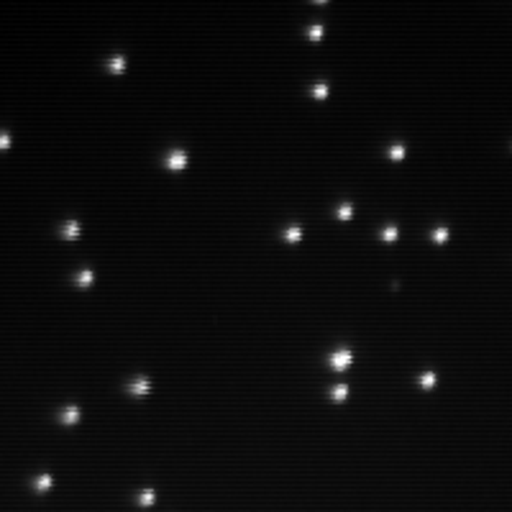

In [124]:
pims.as_grey(frames[0])

In [ ]:
frames

Frame([[0.13531962, 0.13251412, 0.13279687, ..., 1.        , 1.        ,
        1.        ],
       [0.14771882, 0.14969097, 0.14716823, ..., 1.        , 1.        ,
        1.        ],
       [0.13531962, 0.13251412, 0.13279687, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.18331844, 0.18331844, 0.18331844, ..., 1.        , 1.        ,
        1.        ],
       [0.16390157, 0.16192941, 0.16192941, ..., 1.        , 1.        ,
        1.        ],
       [0.18051295, 0.18051295, 0.18331844, ..., 1.        , 1.        ,
        1.        ]], dtype=float32)
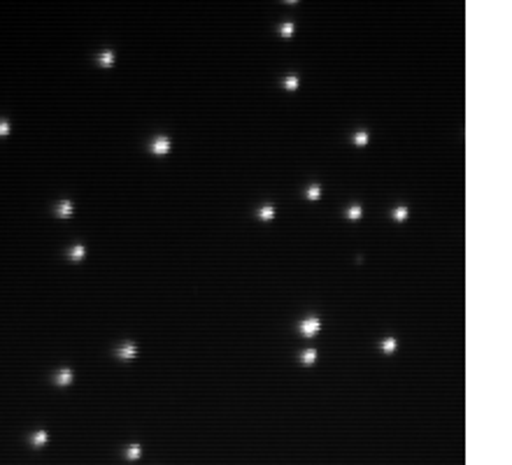

In [118]:
pims.Frame(np.concatenate([frames[0],np.ones_like(frames[0])[:,:20]], axis=1))

In [140]:
found['size'].max()

2.5405302703148873

In [170]:
found = tp.locate(pims.as_grey(frames[0]), 11, minmass=5)
draw = frames[0].copy()

import cv2
for center in zip(found.x.astype(int), found.y.astype(int)):
    cv2.circle(img=draw, center=center, radius=5, color=(1,0,0))

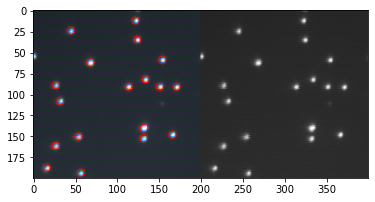

In [176]:
plt.imshow(np.concatenate([draw, np.tile(pims.as_grey(frames[0])[:,:,np.newaxis], (3))],axis=1))

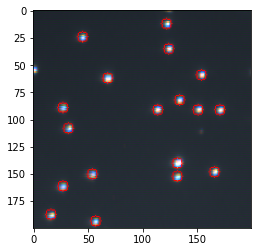

In [171]:
plt.imshow(draw)

Frame([[[0.13725491, 0.12941177, 0.1882353 ],
        [0.13725491, 0.1254902 , 0.1882353 ],
        [0.13725491, 0.1254902 , 0.19215687],
        ...,
        [0.16078432, 0.14509805, 0.20784314],
        [0.16078432, 0.14509805, 0.21176471],
        [0.16078432, 0.14509805, 0.21176471]],

       [[0.10196079, 0.16078432, 0.15294118],
        [0.09803922, 0.16470589, 0.15294118],
        [0.09803922, 0.16078432, 0.15686275],
        ...,
        [0.11372549, 0.18039216, 0.17254902],
        [0.11372549, 0.18431373, 0.1764706 ],
        [0.11764706, 0.1882353 , 0.1764706 ]],

       [[0.13725491, 0.12941177, 0.1882353 ],
        [0.13725491, 0.1254902 , 0.1882353 ],
        [0.13725491, 0.1254902 , 0.19215687],
        ...,
        [0.14901961, 0.14117648, 0.20784314],
        [0.14901961, 0.14117648, 0.21176471],
        [0.15294118, 0.14509805, 0.21176471]],

       ...,

       [[0.1254902 , 0.2       , 0.1882353 ],
        [0.1254902 , 0.2       , 0.1882353 ],
        [0.1254902 , 0.2       , 0.1882353 ],
        ...,
        [0.1254902 , 0.19215687, 0.18431373],
        [0.1254902 , 0.19607843, 0.1882353 ],
        [0.1254902 , 0.19607843, 0.1882353 ]],

       [[0.16470589, 0.15686275, 0.23137255],
        [0.16862746, 0.15294118, 0.23137255],
        [0.16862746, 0.15294118, 0.23137255],
        ...,
        [0.16078432, 0.15294118, 0.22352941],
        [0.16078432, 0.14901961, 0.22352941],
        [0.16862746, 0.15294118, 0.22352941]],

       [[0.1254902 , 0.19607843, 0.1882353 ],
        [0.1254902 , 0.19607843, 0.1882353 ],
        [0.1254902 , 0.2       , 0.1882353 ],
        ...,
        [0.12156863, 0.19607843, 0.18431373],
        [0.12156863, 0.19215687, 0.1882353 ],
        [0.12156863, 0.19215687, 0.1882353 ]]], dtype=float32)
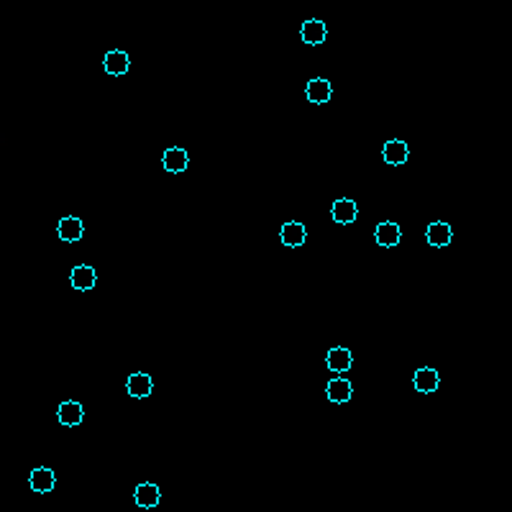

In [154]:
draw

In [150]:
help(tp.annotate)

Help on function annotate in module trackpy.plots:

annotate(centroids, image, circle_size=None, color=None, invert=False, ax=None, split_category=None, split_thresh=None, imshow_style={}, plot_style={})
    Mark identified features with white circles.
    
    Parameters
    ----------
    centroids : DataFrame including columns x and y
    image : image array (or string path to image file)
    circle_size : Deprecated.
        This will be removed in a future version of trackpy.
        Use `plot_style={'markersize': ...}` instead.
    color : single matplotlib color or a list of multiple colors
        default None
    invert : If you give a filepath as the image, specify whether to invert
        black and white. Default True.
    ax : matplotlib axes object, defaults to current axes
    split_category : string, parameter to use to split the data into sections
        default None
    split_thresh : single value or list of ints or floats to split
        particles into sections for

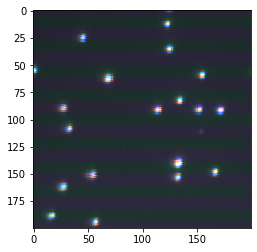

In [128]:
elt = tp.annotate(found, frames[0], a
                 h)

In [ ]:
tp.annotate

In [233]:
search_range = 10
memory = 10

link = tp.linking.Linker(search_range, memory=memory)



True

In [246]:
f.x, f.y

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,12.126255,125.910551,8.401127,2.099839,0.068823,0.468499,32.698922,0.014500,36
1,21.658474,45.899142,8.082548,2.166392,0.064141,0.444137,31.624888,0.015348,36
2,31.933694,130.346696,8.648495,2.166624,0.106683,0.449759,34.169768,0.013480,36
3,58.790204,151.574144,8.378639,2.133857,0.058125,0.477869,32.767493,0.014449,36
4,65.197074,69.288439,13.065505,2.545259,0.043106,0.474121,49.173395,0.007849,36
5,80.847602,129.170071,8.165003,2.317520,0.091392,0.378547,35.333507,0.012769,36
6,85.106866,26.466916,7.505357,2.371228,0.100170,0.357933,32.157906,0.014915,36
7,90.382218,117.800174,8.599771,2.146061,0.063115,0.470373,34.621123,0.013195,36
8,92.625465,154.351564,8.566039,2.179286,0.093261,0.455381,34.704645,0.013144,36
9,92.756763,168.354659,8.729076,2.160926,0.079449,0.461003,34.865007,0.013046,36


1

In [318]:
import datetime

now = datetime.datetime.now()
folder_name = now.strftime('%Y_%b_%d')
filename = '{}_{}-frames.csv'.format(now.strftime('%I:%M:%S-%p'), f.frame.nunique())

'06:06:21-PM_1-frames.csv'

In [277]:
import pandas as pd
import logging
import trackpy as tp

frames = pims.as_grey(pims.open('debug_data/*.bmp'))

f_history = pd.DataFrame()
search_range = 10
memory = 10

link = tp.linking.Linker(search_range, memory=memory)
fall = pd.DataFrame()

for i in range(len(frames)):
    
    f = tp.locate(frames[i], 11, minmass=5, separation=2)    
    t,coords = next(tp.linking.utils.coords_from_df(f, ['y', 'x'], 'frame'))
    if link.hash is None:
        link.init_level(coords, t)a
        
    else:
        link.next_level(coords, t)
    f['particle'] = link.particle_ids
    fall = pd.concat([fall, f])
    
    if i > 100:
        break

fall['particle'] = ids
        #     f_history = tp.link(pd.concat([f_history, f]), 10, memory=10)


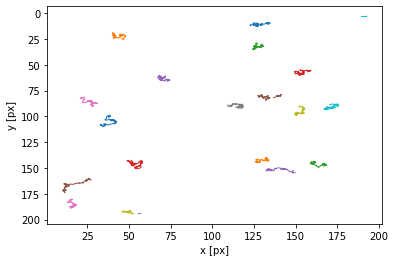

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [278]:
tp.plot_traj(fall)

In [254]:
coords_iter = tp.linking.utils.coords_from_df(f, ['y', 'x'], 'frame')

In [256]:
t, coords = next(coords_iter)

StopIteration: 

In [248]:
tp.link_partial?

In [195]:
ord('\n')

10

In [202]:
tp.locate(frames[0], 11, minmass=5)

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,12.248245,122.986898,8.392085,2.089762,0.060674,0.484989,32.537954,0.014720,0
1,24.840351,45.395739,7.834445,2.220885,0.062243,0.406449,32.297858,0.014906,0
2,35.248387,124.764516,8.521677,2.086052,0.067912,0.484989,33.226108,0.014213,0
3,59.185351,154.697633,8.792643,2.094464,0.083701,0.494807,34.014081,0.013673,0
4,62.474064,68.675224,11.166539,2.464091,0.073461,0.457500,42.251640,0.009788,0
5,82.501879,134.269140,8.360669,2.168945,0.072838,0.459464,33.475429,0.014038,0
6,89.523548,27.519623,7.504574,2.390184,0.109865,0.359324,32.286225,0.014915,0
7,91.162109,114.120644,8.902600,2.131433,0.091785,0.477135,35.567492,0.012721,0
8,91.017604,151.863283,8.588437,2.099437,0.092999,0.481062,34.323491,0.013473,0
9,91.474637,171.605363,8.786752,2.177334,0.045720,0.484989,33.915807,0.013738,0


In [218]:
frames = pims.as_grey(pims.open('debug_data/*.bmp'))
f = tp.batch(frames, 11, minmass=5, separation=1)

Frame 148: 19 features


In [225]:
help(tp.link)

Help on function link in module trackpy.linking.linking:

link(f, search_range, pos_columns=None, t_column='frame', **kwargs)
    link(f, search_range, pos_columns=None, t_column='frame', memory=0,
        predictor=None, adaptive_stop=None, adaptive_step=0.95,
        neighbor_strategy=None, link_strategy=None, dist_func=None,
        to_eucl=None)
    
    Link a DataFrame of coordinates into trajectories.
    
    Parameters
    ----------
    f : DataFrame
        The DataFrame must include any number of column(s) for position and a
        column of frame numbers. By default, 'x' and 'y' are expected for
        position, and 'frame' is expected for frame number. See below for
        options to use custom column names.
    search_range : float or tuple
        the maximum distance features can move between frames,
        optionally per dimension
    pos_columns : list of str, optional
        Default is ['y', 'x'], or ['z', 'y', 'x'] when 'z' is present in f
    t_column : str, 

In [224]:
%timeit tp.link(f, 10, memory=10)

Frame 148: 19 trajectories present.
566 ms ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Frame 148: 19 trajectories present.


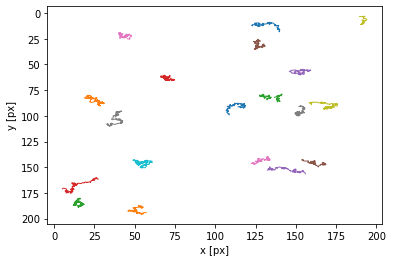

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [223]:
l = tp.link(f, 10, memory=10)
tp.plot_traj(l)

Frame 148: 19 trajectories present.


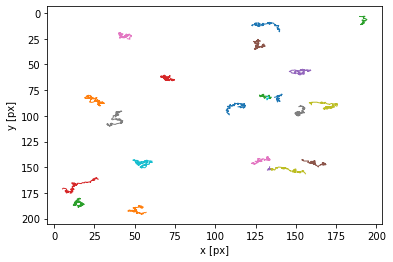

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [222]:
l = tp.link(f, 2, memory=10)
tp.plot_traj(l)

In [79]:
l = tp.link(tp.batch(frames[:2], 11, minmass=5), 10, memory=3)


Frame 1: 18 trajectories present.


In [60]:
found[found.frame == 0]

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,12.248245,122.986898,8.392085,2.089762,0.060674,0.484989,32.537954,0.014720,0
1,24.840351,45.395739,7.834445,2.220885,0.062243,0.406449,32.297858,0.014906,0
2,35.248387,124.764516,8.521677,2.086052,0.067912,0.484989,33.226108,0.014213,0
3,59.185351,154.697633,8.792643,2.094464,0.083701,0.494807,34.014081,0.013673,0
4,62.474064,68.675224,11.166539,2.464091,0.073461,0.457500,42.251640,0.009788,0
5,82.501879,134.269140,8.360669,2.168945,0.072838,0.459464,33.475429,0.014038,0
6,89.523548,27.519623,7.504574,2.390184,0.109865,0.359324,32.286225,0.014915,0
7,91.162109,114.120644,8.902600,2.131433,0.091785,0.477135,35.567492,0.012721,0
8,91.017604,151.863283,8.588437,2.099437,0.092999,0.481062,34.323491,0.013473,0
9,91.474637,171.605363,8.786752,2.177334,0.045720,0.484989,33.915807,0.013738,0


In [62]:
tp.link

<function trackpy.linking.linking.link(f, search_range, pos_columns=None, t_column='frame', **kwargs)>

In [184]:
fou

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,12.248245,122.986898,8.392085,2.089762,0.060674,0.484989,32.537954,0.014720,0
1,24.840351,45.395739,7.834445,2.220885,0.062243,0.406449,32.297858,0.014906,0
2,35.248387,124.764516,8.521677,2.086052,0.067912,0.484989,33.226108,0.014213,0
3,59.185351,154.697633,8.792643,2.094464,0.083701,0.494807,34.014081,0.013673,0
4,62.474064,68.675224,11.166539,2.464091,0.073461,0.457500,42.251640,0.009788,0
5,82.501879,134.269140,8.360669,2.168945,0.072838,0.459464,33.475429,0.014038,0
6,89.523548,27.519623,7.504574,2.390184,0.109865,0.359324,32.286225,0.014915,0
7,91.162109,114.120644,8.902600,2.131433,0.091785,0.477135,35.567492,0.012721,0
8,91.017604,151.863283,8.588437,2.099437,0.092999,0.481062,34.323491,0.013473,0
9,91.474637,171.605363,8.786752,2.177334,0.045720,0.484989,33.915807,0.013738,0


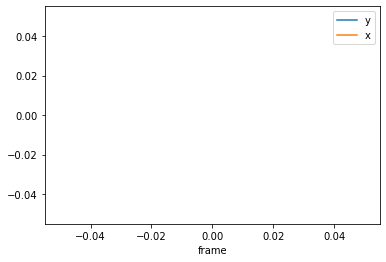

In [181]:
t = tp.link(found, 3, memory=3)
t1 = tp.filter_stubs(t, 25)

drift = tp.compute_drift(t1)
drift.plot()

t2 = tp.subtract_drift(t1, drift)

ValueError: DataFrame of trajectories is empty.

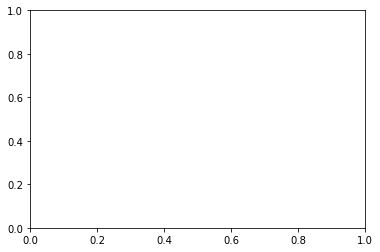

In [182]:
tp.plot_traj(t2)

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

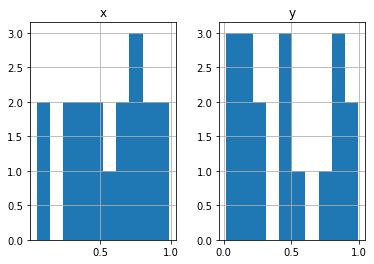

In [39]:
tp.subpx_bias(found)

In [26]:
data_path = 'debug_data'

def load_info(data_path):
    info = pd.DataFrame(glob.glob('{}/*.bmp'.format(data_path)), columns=['path'])
    info['frame'] = info.path.str.replace('.bmp', '').str.split('Frame ').str[1].astype(int)
    info.set_index('frame', inplace=True)
    return info.sort_index()

def load_images(info_df):
    
    for path in df.path:
        

,path
frame,
1,debug_data/debug_data Frame 1.bmp
2,debug_data/debug_data Frame 2.bmp
3,debug_data/debug_data Frame 3.bmp
4,debug_data/debug_data Frame 4.bmp
5,debug_data/debug_data Frame 5.bmp
...,...
145,debug_data/debug_data Frame 145.bmp
146,debug_data/debug_data Frame 146.bmp
147,debug_data/debug_data Frame 147.bmp


In [68]:
import sys
max_bytes = 1e6
size = sys.getsizeof(img)
np.floor(max_bytes/size)

8.0

In [70]:
%run tracker.py

In [82]:
load_images(info, max_bytes=1e8)[0].shape

(200, 200, 3)

In [96]:
gray

array([[35, 35, 35, ..., 40, 40, 40],
       [36, 37, 36, ..., 41, 41, 42],
       [35, 35, 35, ..., 39, 39, 40],
       ...,
       [45, 45, 45, ..., 44, 44, 44],
       [43, 42, 42, ..., 42, 41, 42],
       [44, 44, 45, ..., 44, 44, 44]], dtype=uint8)

In [99]:
img.shape

(200, 200, 3)

In [97]:
np.tile(gray[:,:,None], (3)).shape

(200, 200, 3)

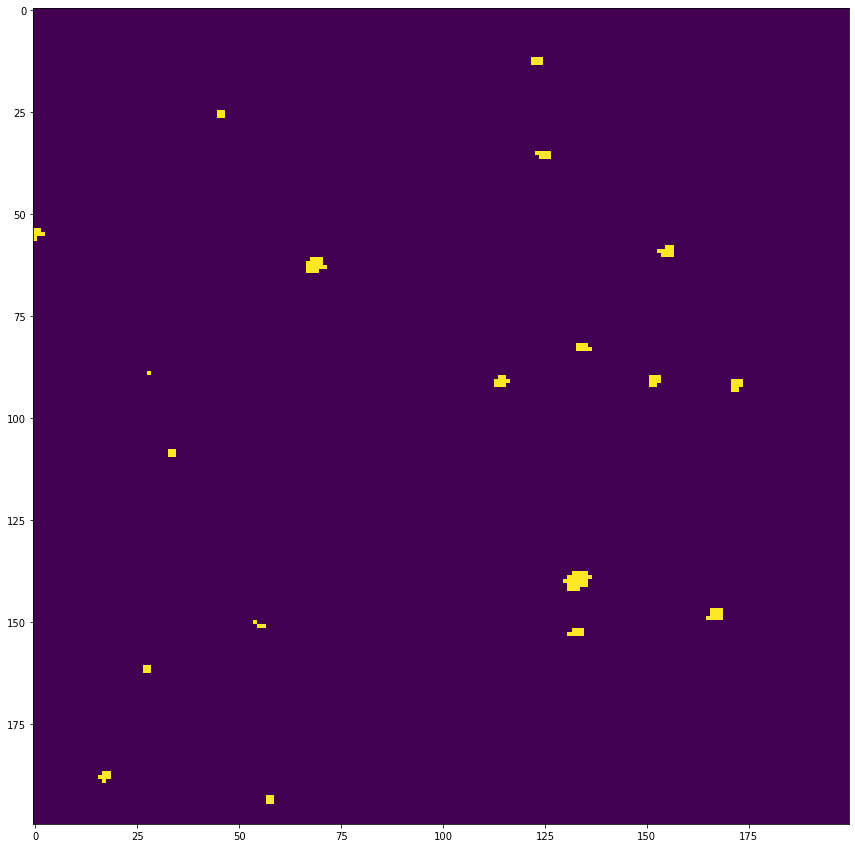

In [48]:
img = cv2.imread(info.path.iloc[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(15,15))
plt.imshow(cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)[1])